# Домашнее задание

Будем прогнозировать количество проданного товара в городе Бангалор (Индия)

## Импорт библиотек и загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


%matplotlib inline

pd.options.display.float_format = "{:.2f}".format

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

In [2]:
df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [3]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Оставим только данные по городу Бангалор

In [4]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [5]:
# Удалим лишние столбцы
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [6]:
ts.head()

,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


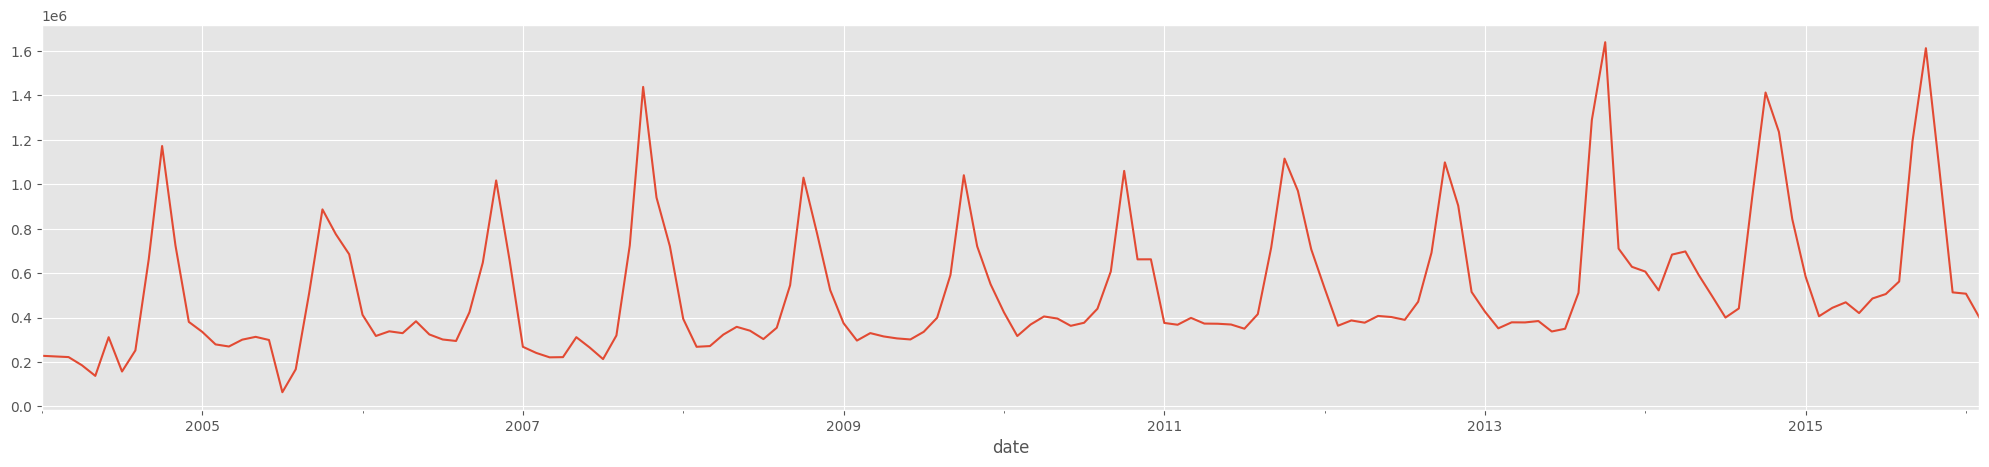

In [7]:
ts.quantity.plot(figsize=(25,5));

## Обучение адаптивных моделей

Разбейте данные (quantity) на train и test.

* train - первые 85% данных

* test - следующие 15% данных

Проверьте, что в тест попало 22 измерения.

In [15]:
# df.date = pd.DatetimeIndex(df.date)

# # Отсортируем и добавим date в индекс

# df = df.sort_values(by="date")

# df.index = pd.PeriodIndex(df.date, freq="M")

In [25]:
ts['datetime'] = ts.index.to_timestamp()

In [29]:
ts_dt_ix = ts.set_index('datetime')

In [40]:
ts

,quantity,datetime
date,,
2004-01,227832,2004-01-01
2004-02,225133,2004-02-01
2004-03,221952,2004-03-01
2004-04,185150,2004-04-01
2004-05,137390,2004-05-01
...,...,...
2015-10,1612160,2015-10-01
2015-11,1071872,2015-11-01
2015-12,513186,2015-12-01


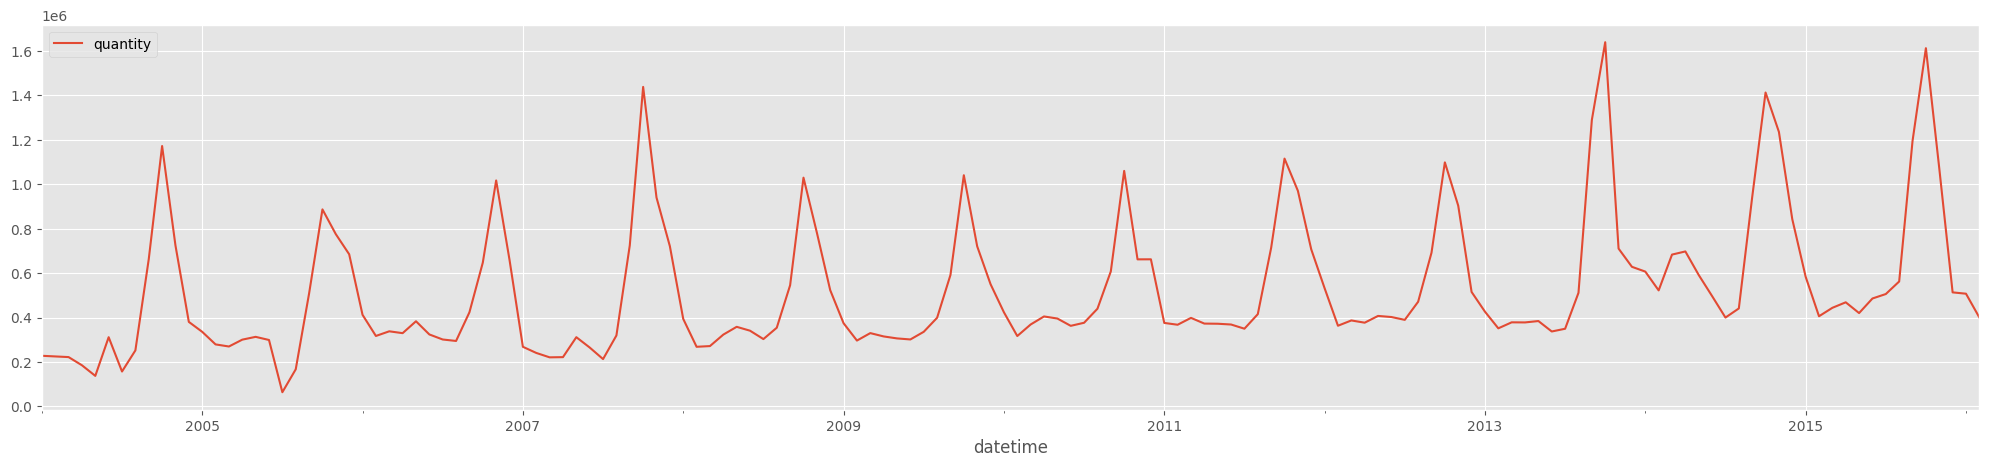

In [53]:
ts_dt_ix.plot(figsize=(25,5));

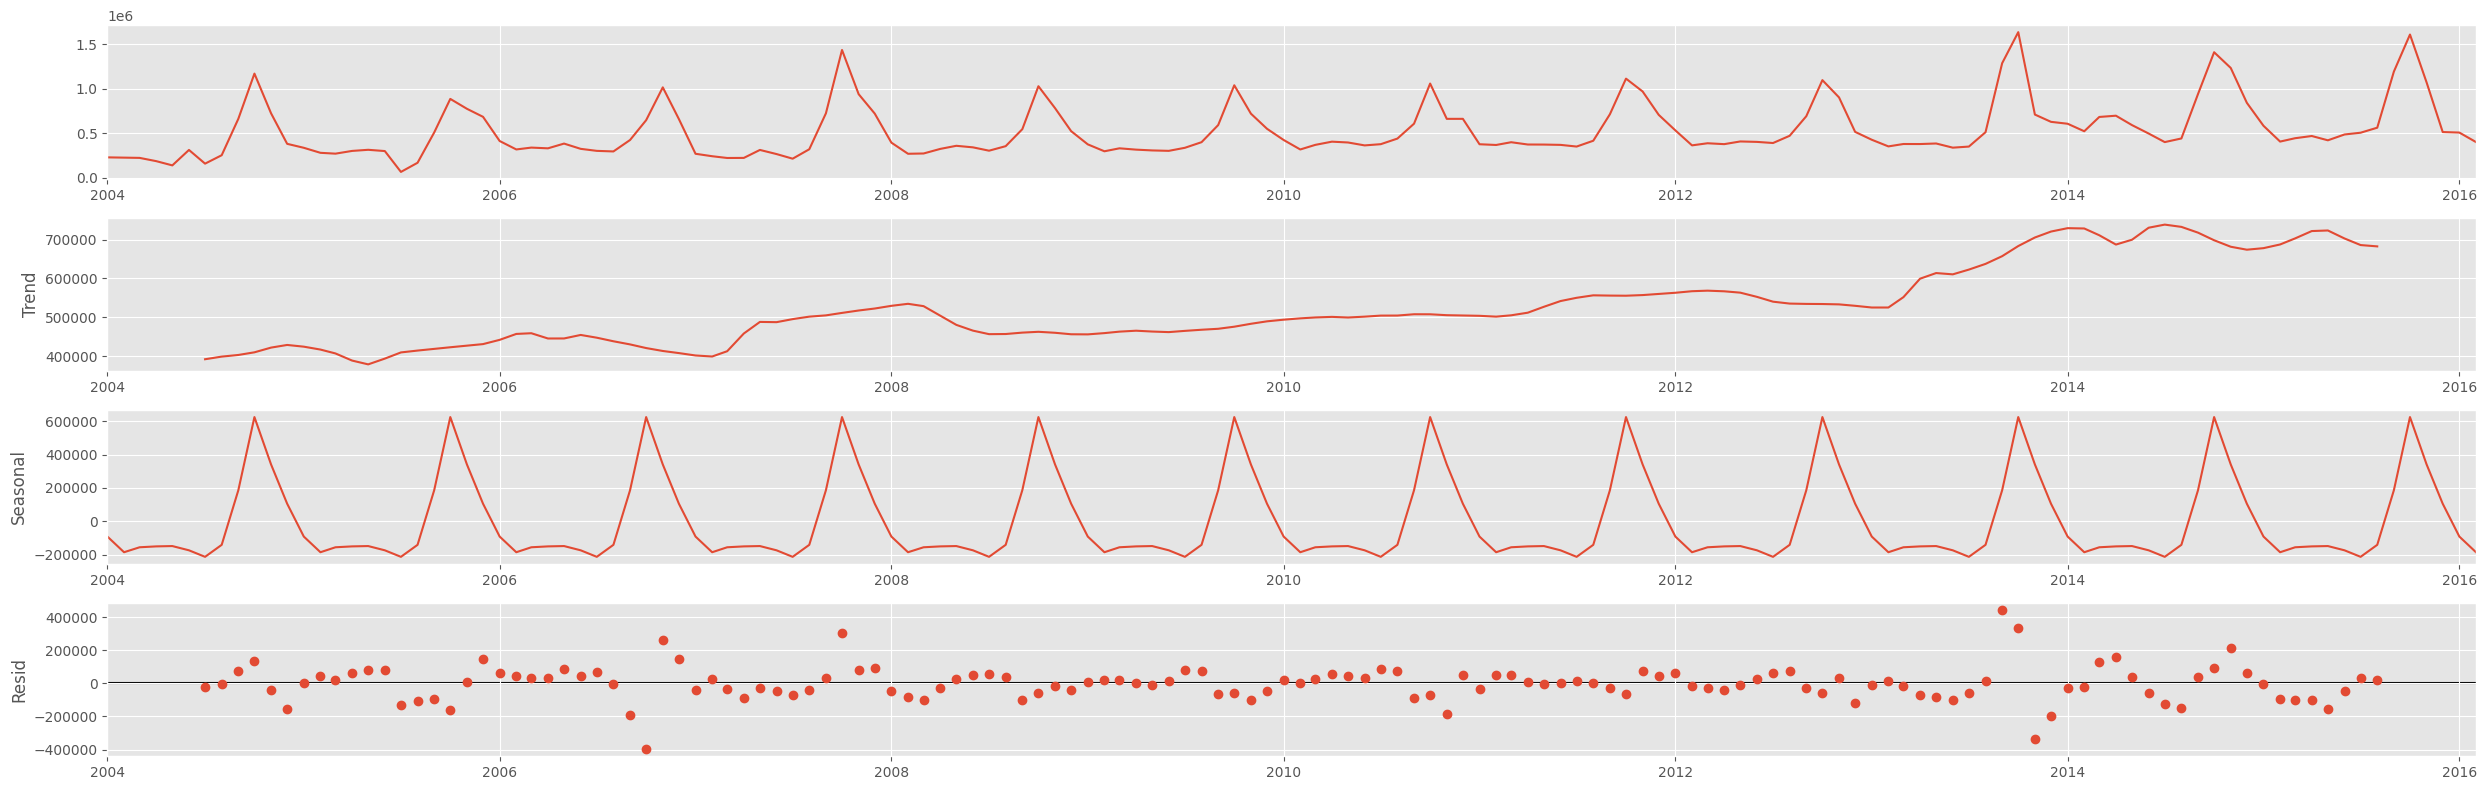

In [61]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts_dt_ix)
# res = sm.tsa.seasonal_decompose(ts_dt_ix, period=12) # same as default
# res = sm.tsa.seasonal_decompose(ts_dt_ix, model='multiplicative')
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

In [30]:
# split_index = int(0.85*len(ts))
# split_time = ts.index[split_index]

# Train = ts[:split_time]
# Test = ts[split_time:]

# print(f'Train shape = {Train.shape}')
# print(f'Test shape = {Test.shape}')

In [90]:
ts_dt_ix.shape

(146, 1)

In [91]:
split_index = int(0.85*len(ts_dt_ix))
split_time = ts_dt_ix.index[split_index]

# Train = ts_dt_ix[:split_time]
# Test = ts_dt_ix[split_time:]

Train = ts_dt_ix.iloc[:split_index]
Test = ts_dt_ix.iloc[split_index:]

print(f'Train shape = {Train.shape}')
print(f'Test shape = {Test.shape}')

Train shape = (124, 1)
Test shape = (22, 1)


In [92]:
Train

,quantity
datetime,
2004-01-01,227832
2004-02-01,225133
2004-03-01,221952
2004-04-01,185150
2004-05-01,137390
...,...
2013-12-01,628220
2014-01-01,606710
2014-02-01,522132


Обучите следующие модели на тренировочных данных и сделайте прогноз на 22 шага вперед (величина тестовых данных), нарисуйте прогнозы:

1) Простое экспоненциальное сглаживание с автоматически подбираемым $\alpha$

2) Модель Хольта (аддитивную) с автоматическим подбором гиперпараметров

3) Аддитивную модель Хольта с автоматическим подбором гиперпараметров и затухающим трендом

In [93]:
N_forecast_steps = len(Test)

In [94]:
fit_simple = SimpleExpSmoothing(Train, initialization_method="estimated").fit()
fcast_simple = fit_simple.forecast(N_forecast_steps).rename(r"$\alpha=%s$" % fit_simple.model.params["smoothing_level"])

/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [95]:
fit_Holt = Holt(Train, initialization_method="estimated").fit()
fcast_Holt = fit_Holt.forecast(N_forecast_steps).rename("Holt's linear trend")

/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [96]:
fit_Holt_damped = Holt(Train, damped_trend=True, initialization_method="estimated").fit()
fcast_Holt_damped = fit_Holt_damped.forecast(N_forecast_steps).rename("Additive Damped")

/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


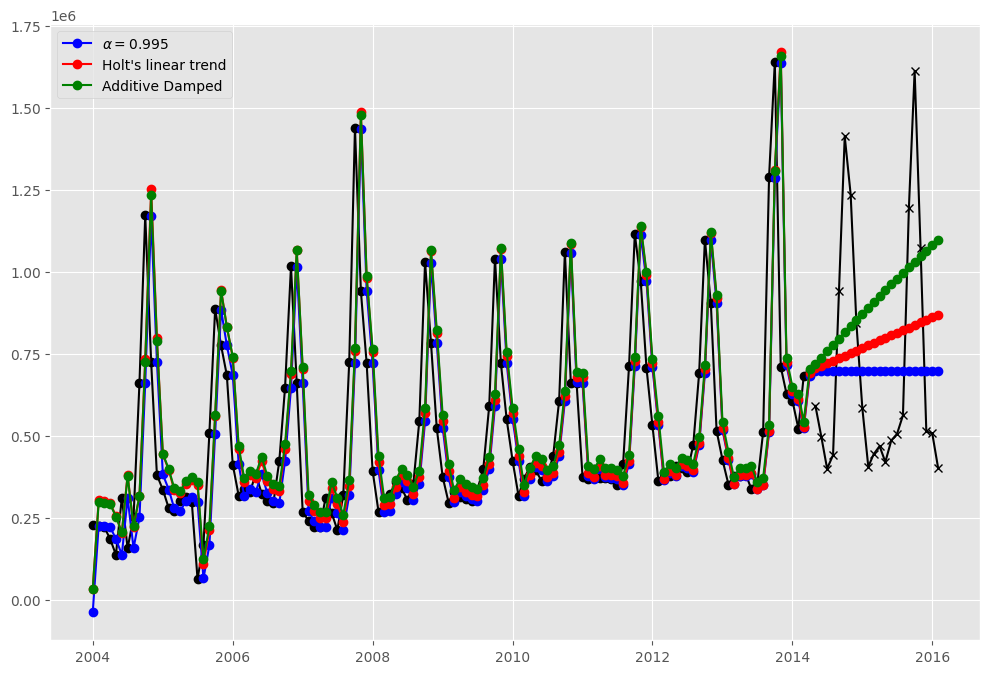

In [97]:
plt.figure(figsize=(12, 8))
plt.plot(Train, marker="o", color="black")
plt.plot(Test, marker="x", color="black")
plt.plot(fit_simple.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast_simple, marker="o", color="blue")
plt.plot(fit_Holt.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast_Holt, marker="o", color="red")
plt.plot(fit_Holt_damped.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast_Holt_damped, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast_simple.name, fcast_Holt.name, fcast_Holt_damped.name])
plt.show()

In [98]:
Test['quantity']

datetime
2014-05-01     591250
2014-06-01     496447
2014-07-01     399867
2014-08-01     440875
2014-09-01     941818
2014-10-01    1412686
2014-11-01    1235389
2014-12-01     842653
2015-01-01     583681
2015-02-01     405716
2015-03-01     443687
2015-04-01     468522
2015-05-01     420072
2015-06-01     485652
2015-07-01     505717
2015-08-01     562187
2015-09-01    1194608
2015-10-01    1612160
2015-11-01    1071872
2015-12-01     513186
2016-01-01     507223
2016-02-01     400359
Name: quantity, dtype: int64

In [99]:
fcast_Holt_damped

2014-05-01    717588.16
2014-06-01    737524.67
2014-07-01    757261.82
2014-08-01    776801.59
2014-09-01    796145.97
2014-10-01    815296.90
2014-11-01    834256.33
2014-12-01    853026.16
2015-01-01    871608.29
2015-02-01    890004.60
2015-03-01    908216.94
2015-04-01    926247.17
2015-05-01    944097.09
2015-06-01    961768.51
2015-07-01    979263.22
2015-08-01    996582.98
2015-09-01   1013729.54
2015-10-01   1030704.64
2015-11-01   1047509.98
2015-12-01   1064147.28
2016-01-01   1080618.20
2016-02-01   1096924.41
Freq: MS, Name: Additive Damped, dtype: float64

## Quiz

У какой из трех обученных моделей самый быстро возрастающий тренд?

Обучите четыре модели Хольта-Винтерса на тренировочных данных и сделайте прогноз на 22 шага вперед (величина тестовых данных), нарисуйте прогнозы:

1) Модель с аддитивными трендом и сезонностью

2) Модель с аддитивным трендом и мультипликативной сезонностью

3) Модель с аддитивными трендом и сезонностью и затухающим трендом

4) Модель с аддитивным трендом и мультипликативной сезонностью и затухающим трендом

In [100]:
fit1 = ExponentialSmoothing(
    Train,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit2 = ExponentialSmoothing(
    Train,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit3 = ExponentialSmoothing(
    Train,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit4 = ExponentialSmoothing(
    Train,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()

results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)

/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/opv002/miniconda3/envs/test_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


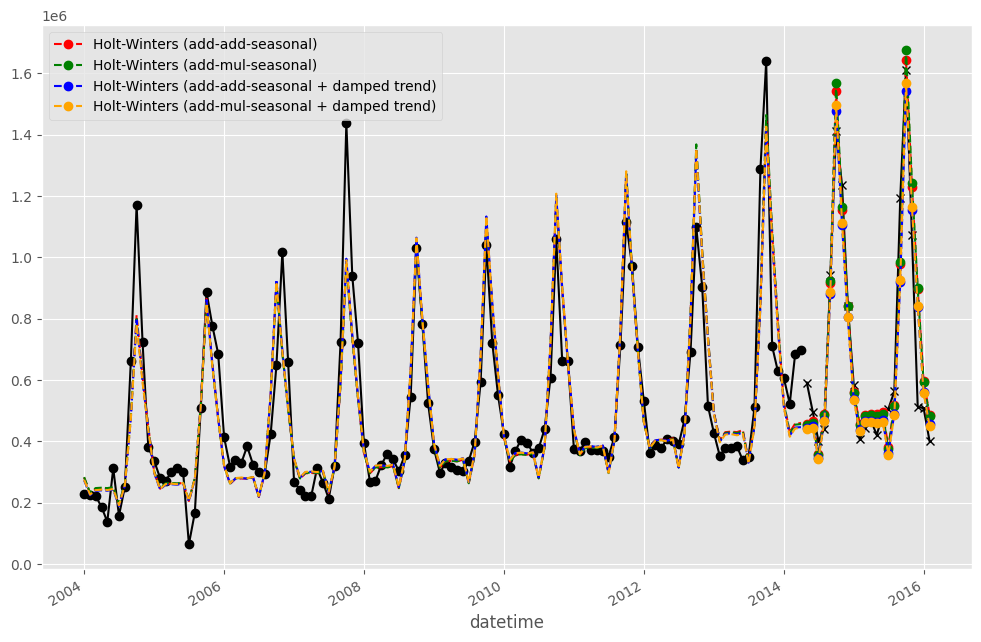

In [101]:
plt.figure(figsize=(12, 8))

plt.plot(Train,
    marker="o",
    color="black",
)

plt.plot(Test,
    marker="x",
    color="black",
)

fit1.fittedvalues.plot(style="--", color="red")
fit2.fittedvalues.plot(style="--", color="green")
fit3.fittedvalues.plot(style="--", color="blue")
fit4.fittedvalues.plot(style="--", color="orange")

fit1.forecast(N_forecast_steps).rename("Holt-Winters (add-add-seasonal)").plot(
    style="--", marker="o", color="red", legend=True
)
fit2.forecast(N_forecast_steps).rename("Holt-Winters (add-mul-seasonal)").plot(
    style="--", marker="o", color="green", legend=True
)
fit3.forecast(N_forecast_steps).rename("Holt-Winters (add-add-seasonal + damped trend)").plot(
    style="--", marker="o", color="blue", legend=True
)
fit4.forecast(N_forecast_steps).rename("Holt-Winters (add-mul-seasonal + damped trend)").plot(
    style="--", marker="o", color="orange", legend=True
)

plt.show()
# print(
#     "Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality."
# )

Вычислите RMSE (корень из среднеквадратичной ошибки) на тестовых данных для каждого из четырех прогнозов.

In [121]:
from sklearn.metrics import mean_squared_error

print(f'Holt-Winters (add-add-seasonal) MSE: {mean_squared_error(Test.quantity, fit1.forecast(N_forecast_steps))}')
print(f'Holt-Winters (add-mul-seasonal) MSE: {mean_squared_error(Test.quantity, fit2.forecast(N_forecast_steps))}')
print(f'Holt-Winters (add-add-seasonal + damped trend) MSE: {mean_squared_error(Test.quantity, fit3.forecast(N_forecast_steps))}')
print(f'Holt-Winters (add-mul-seasonal + damped trend) MSE: {mean_squared_error(Test.quantity, fit4.forecast(N_forecast_steps))}')

Holt-Winters (add-add-seasonal) MSE: 14055750278.211054
Holt-Winters (add-mul-seasonal) MSE: 14606272697.635607
Holt-Winters (add-add-seasonal + damped trend) MSE: 12977276146.645353
Holt-Winters (add-mul-seasonal + damped trend) MSE: 12972835066.991941


In [122]:
np.around(np.sqrt(12972835066.991941))

113898.0

## Quiz

Какая модель справилась лучше остальных?

## Quiz

Чему равно значение RMSE для лучшей модели? Ответ округлите до целого числа.

В предыдущем домашнем задании мы работали с логарифмированным рядом и вычисляли RMSE для него.

Вычислите ошибки последних четырех моделей для логарифмов правильных ответов и прогнозов.

In [ ]:
# ваш код здесь

## Quiz

Какое семейство моделей лучше справилось с решением задачи:
SARIMAX или модели Хольта-Винтерса?

## Опциональное задание (без проверки)

Воспользуйтесь экспоненциальными моделями из библиотеки Orbit для получения прогноза в данной задаче.

In [ ]:
# ваш код здесь